<a href="https://colab.research.google.com/github/ij451r/Kaggle-Notebooks/blob/master/EmbryoClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
!pip install torch torchvision

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/competitions/world-championship-2023-embryo-classification/data'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mohammedjasir
Your Kaggle Key: ··········


100%|██████████| 30.1M/30.1M [00:01<00:00, 22.0MB/s]



Extracting archive ./world-championship-2023-embryo-classification/world-championship-2023-embryo-classification.zip to ./world-championship-2023-embryo-classification


In [ ]:
DATA_DIR = "/content/world-championship-2023-embryo-classification/hvwc23"
TRAIN_DIR = DATA_DIR+"/train"
TEST_DIR = DATA_DIR+"/test"
TRAIN_CLASS_DATA = DATA_DIR + "/train.csv"

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [ ]:
df = pd.read_csv(TRAIN_CLASS_DATA)
df.head()

,Image,Class
0,D3_405.jpg,0
1,D3_523.jpg,0
2,D3_750.jpg,0
3,D3_427.jpg,0
4,D3_042.jpg,0


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file=None, data=None, root_dir=None, transform=None):
        if csv_file:
            self.data = pd.read_csv(csv_file)
        else:
            self.data = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name)
        if self.data.shape[1]>1:
          try:
            label = int(self.data.iloc[idx, 1])
          except:
            label = None
        else:
          label=None

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
dataset = CustomDataset(csv_file=TRAIN_CLASS_DATA, root_dir=TRAIN_DIR)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

0 242 240


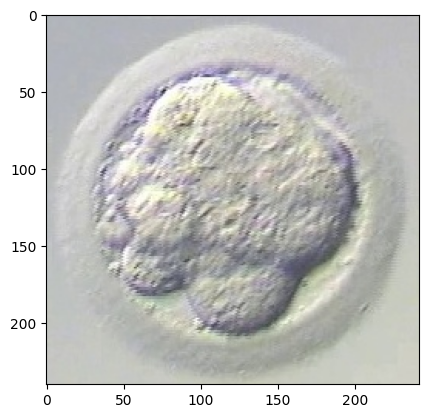

In [ ]:
image, Class = dataset[1]
width, height = image.size
print(Class, width, height)
plt.imshow(image)

In [ ]:
image_size=224
batch_size = 128

In [ ]:
ratio_dict = {}
for idx,data in enumerate(dataset):
  img,cls = data
  width, height = img.size
  if width<image_size or height<image_size:
    print(f"The image at index {idx} has the dimension {width}x{height}")
  if f"{width}x{height}" not in ratio_dict.keys():
    ratio_dict[f"{width}x{height}"] = 1
  else:
    ratio_dict[f"{width}x{height}"] += 1
print(ratio_dict)

The image at index 117 has the dimension 171x170
The image at index 308 has the dimension 102x104
{'256x256': 707, '242x240': 1, '446x450': 1, '486x463': 1, '436x446': 1, '349x332': 1, '435x406': 2, '346x351': 1, '236x230': 1, '414x447': 1, '248x248': 1, '244x250': 1, '258x256': 1, '444x446': 1, '303x297': 1, '434x436': 1, '462x419': 1, '462x435': 1, '355x363': 1, '476x443': 1, '426x417': 1, '357x367': 1, '271x278': 1, '276x260': 1, '347x333': 1, '171x170': 1, '439x430': 1, '257x248': 1, '435x421': 1, '248x234': 1, '479x464': 1, '418x378': 1, '246x245': 1, '249x250': 2, '444x425': 1, '437x466': 1, '440x401': 1, '344x349': 1, '333x337': 1, '270x256': 1, '481x449': 1, '364x364': 1, '244x251': 1, '349x328': 1, '228x243': 1, '241x244': 1, '247x240': 2, '230x228': 1, '337x330': 1, '343x351': 1, '363x349': 2, '474x436': 1, '437x446': 1, '405x395': 1, '248x242': 1, '382x397': 1, '425x445': 1, '389x360': 1, '250x266': 1, '451x452': 1, '429x401': 1, '354x353': 1, '399x369': 1, '433x437': 1, '44

In [ ]:
vals = []
for ratio in list(ratio_dict.keys()):
  w, h = map(int,ratio.split('x'))
  vals.append(round(w/h,2))
print(set(vals))

{0.99, 1.0, 1.05, 1.01, 0.98, 1.07, 1.03, 0.93, 1.02, 1.1, 1.06, 1.08, 0.92, 1.09, 0.94, 0.95, 1.11, 0.96, 1.04, 0.97}


In [ ]:
val_tfms = tt.Compose([tt.Resize(image_size),
                         tt.CenterCrop(image_size),
                         tt.ToTensor()
                         ])

In [ ]:
stat_ds = CustomDataset(csv_file=TRAIN_CLASS_DATA, root_dir=TRAIN_DIR, transform=val_tfms)
stat_dl = DataLoader(stat_ds)
nimages = 0
mean = 0.
std = 0.
for batch, _ in stat_dl:
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0)
    std += batch.std(2).sum(0)

# Final step
mean /= nimages
std /= nimages

print(mean,std)

tensor([0.6723, 0.6740, 0.6523]) tensor([0.1280, 0.1325, 0.1397])


In [ ]:
stats = (0.6723, 0.6740, 0.6523), (0.1280, 0.1325, 0.1397)

In [ ]:
train_tfms = tt.Compose([tt.RandomHorizontalFlip(),
                         tt.RandomAffine(degrees= (0,10), translate=(0,0.07), scale=(1,1.1), fill=0.7),
                         tt.RandomApply(torch.nn.ModuleList([tt.ColorJitter(),]),p=0.1),
                         tt.Resize(image_size),
                         tt.CenterCrop(image_size),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)
                         ])
val_tfms = tt.Compose([tt.Resize(image_size),
                         tt.CenterCrop(image_size),
                         tt.ToTensor(),
                         tt.Normalize(*stats)
                         ])
pred_tfms = tt.Compose([
                         tt.ToTensor()
                         ])

In [ ]:
print(f"{len(df[df['Class']==0])/len(df):.2f}% of values belong to class 0")
print(f"{len(df[df['Class']==1])/len(df):.2f}% of values belong to class 0")

0.85% of values belong to class 0
0.15% of values belong to class 0


This shows that the data is heavily biased and we'll have to handle that correctly

In [ ]:
from sklearn.model_selection import train_test_split
all_positive_df = df[df['Class']==1]
all_negative_df = df[df['Class']==0]
df_train_pos, df_valid_pos = train_test_split(all_positive_df, test_size=0.2, random_state=22)
df_train_neg, df_valid_neg = train_test_split(all_negative_df, test_size=0.2, random_state=22)
df_train = pd.concat([df_train_pos,df_train_neg])
df_valid = pd.concat([df_valid_pos,df_valid_neg])

Let us now divide the files as per the dataframe to corresponding folders

In [ ]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 712 to 289
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   169 non-null    object
 1   Class   169 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.0+ KB


In [ ]:
print(f"{df_valid[df_valid['Class']==1].shape[0]/df_valid.shape[0]:.2f}% in validation set belongs to class 1")
print(f"{df_train[df_train['Class']==1].shape[0]/df_train.shape[0]:.2f}% in train set belongs to class 1")

0.15% in validation set belongs to class 1
0.15% in train set belongs to class 1


In [ ]:
import shutil

VALID_DIR = DATA_DIR+"/valid"
TRAIN_COPY_DIR = DATA_DIR+"/train_copy"
os.makedirs(VALID_DIR,exist_ok=True)
os.makedirs(TRAIN_COPY_DIR,exist_ok=True)

for image_name in df_valid['Image']:
    source_file_path = os.path.join(TRAIN_DIR, image_name)
    destination_file_path = os.path.join(VALID_DIR, image_name)
    shutil.copy(source_file_path, destination_file_path)
for image_name in df_train['Image']:
    source_file_path = os.path.join(TRAIN_DIR, image_name)
    destination_file_path = os.path.join(TRAIN_COPY_DIR, image_name)
    shutil.copy(source_file_path, destination_file_path)

In [ ]:
train_ds = CustomDataset(data=df_train, root_dir=TRAIN_COPY_DIR, transform=train_tfms)
val_ds = CustomDataset(data=df_valid, root_dir=VALID_DIR, transform=val_tfms)
len(train_ds), len(val_ds)

(671, 169)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

Label: 0
torch.Size([3, 224, 224])


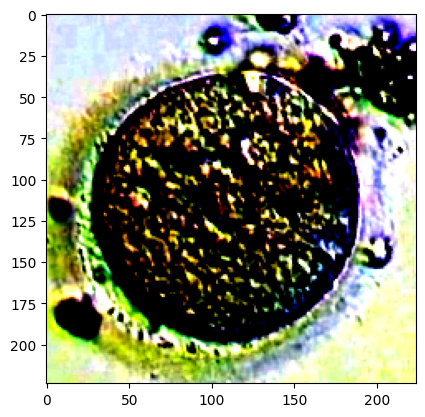

In [ ]:
image, label = train_ds[100]
plt.imshow(image.permute(1, 2, 0))
print('Label:', label)
print(image.shape)

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        #print(images.shape)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        #print(denorm_images.shape)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

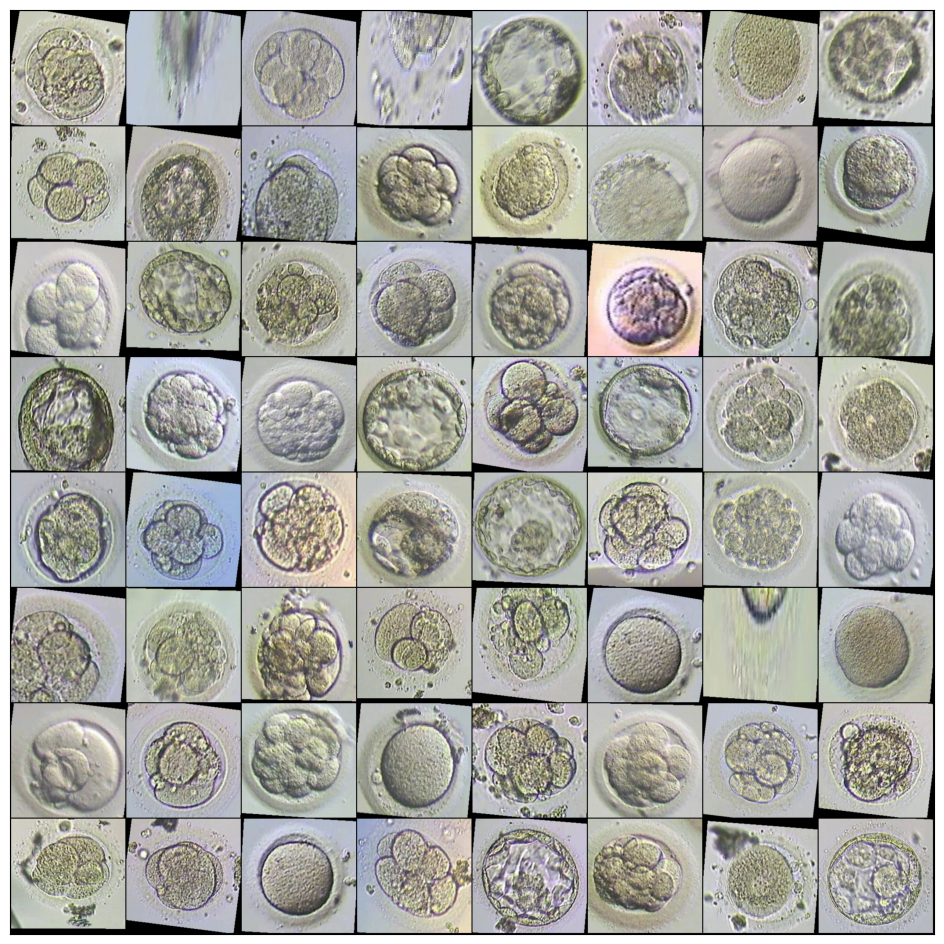

In [ ]:
show_batch(train_dl)

In [ ]:
for images, labels in valid_dl:
  print(images.shape)
  break

torch.Size([128, 3, 224, 224])


In [ ]:
for images, labels in train_dl:
  print(images.shape)
  break

torch.Size([128, 3, 224, 224])


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
def accuracy(outputs, labels, threshold=0.5):
    # Convert the model's output into binary predictions
    preds = (outputs > threshold).float()
    # Compare the predictions with the actual labels and calculate the accuracy
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return torch.tensor(correct / total)

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        class_weights = [1.0 / 0.85, 1.0 / 0.15]
        images, labels = batch
        labels= labels.unsqueeze(1)
        out = self(images)                  # Generate predictions
        out = out.to(torch.float)
        labels = labels.to(torch.float)
        loss = F.binary_cross_entropy(input = out, target = labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        class_weights = [1.0 / 0.85, 1.0 / 0.15]
        images, labels = batch
        labels= labels.unsqueeze(1)
        out = self(images)
        out = out.to(torch.float)
        labels = labels.to(torch.float)
        loss = F.binary_cross_entropy(input = out, target = labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block_ker_4(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4,stride=2, padding=1), #convolutional layer with kernel size = 4 and stride = 2
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

def conv_block_ker_3(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),   #convolutional layer with kernel size = 3 and stride = 1
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # batch_size * in_channel * 224 * 224
        self.conv1 = conv_block_ker_4(in_channels, 64)
        # batch_size * 64 * 112 * 112  (Spatial dimensions reduced by 2)
        self.conv2 = conv_block_ker_4(64, 128)
        # batch_size * 128 * 56 * 56  (Spatial dimensions reduced by 2)
        self.res1 = nn.Sequential(conv_block_ker_3(128, 128), conv_block_ker_3(128, 128))
        # batch_size * 128 * 56 * 56
        self.conv3 = conv_block_ker_4(128, 256, pool=True)
        # batch_size * 256 * 28 * 28  (Spatial dimensions reduced by 2)
        self.conv4 = conv_block_ker_4(256, 512)
        # batch_size * 512 * 14 * 14  (Spatial dimensions reduced by 2)
        self.res2 = nn.Sequential(conv_block_ker_3(512, 512), conv_block_ker_3(512, 512))
        # batch_size * 512 * 14 * 14
        self.classifier = self.classifier = nn.Sequential(
                                                            nn.MaxPool2d(7),  # Reduce spatial dimensions
                                                            nn.Flatten(),
                                                            nn.Dropout(0.2),
                                                            nn.Linear(512, 1),  # Output layer with a single neuron
                                                            nn.Sigmoid()  # Sigmoid activation for binary classification
                                                        )


    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, 2), device)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 0.7073257565498352, 'val_acc': 0.12252286076545715}]

In [ ]:
epochs = 10
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay)

Epoch [0], last_lr: 0.00002, train_loss: 1.5156, val_loss: 0.6274, val_acc: 0.8526
Epoch [1], last_lr: 0.00007, train_loss: 1.2875, val_loss: 0.6077, val_acc: 0.8526
Epoch [2], last_lr: 0.00010, train_loss: 0.7309, val_loss: 0.6308, val_acc: 0.8365
Epoch [3], last_lr: 0.00010, train_loss: 0.5324, val_loss: 0.6399, val_acc: 0.6569
Epoch [4], last_lr: 0.00008, train_loss: 0.5358, val_loss: 0.5997, val_acc: 0.7076
Epoch [5], last_lr: 0.00006, train_loss: 0.5228, val_loss: 0.6071, val_acc: 0.6652
Epoch [6], last_lr: 0.00004, train_loss: 0.4703, val_loss: 0.5976, val_acc: 0.6921
Epoch [7], last_lr: 0.00002, train_loss: 0.5122, val_loss: 0.5303, val_acc: 0.7731
Epoch [8], last_lr: 0.00000, train_loss: 0.5205, val_loss: 0.5604, val_acc: 0.7721
Epoch [9], last_lr: 0.00000, train_loss: 0.4857, val_loss: 0.5246, val_acc: 0.7999
CPU times: user 33.8 s, sys: 2.85 s, total: 36.7 s
Wall time: 37.9 s


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

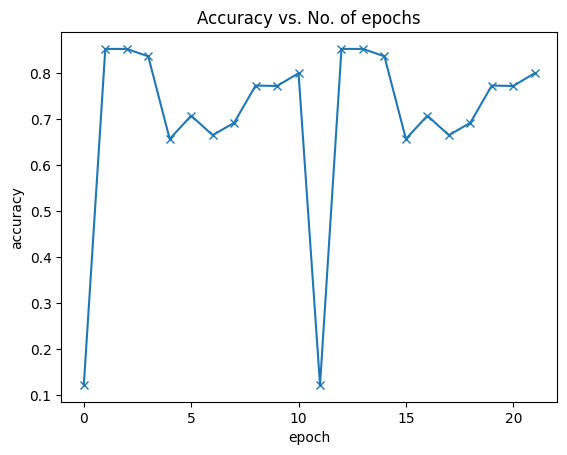

In [ ]:
plot_accuracies(history)

In [ ]:
files = os.listdir(TEST_DIR)
test_df = pd.DataFrame(files)
test_df['Class'] = 0
test_df.columns = ['Image', 'Class']


In [ ]:
test_df.head()

,Image,Class
0,D3_429.jpg,0
1,D3_149.jpg,0
2,D5_377.jpg,0
3,D3_583.jpg,0
4,D3_232.jpg,0


In [ ]:
test_ds = CustomDataset(data = test_df, root_dir=TEST_DIR, transform=val_tfms)

In [ ]:
for image,_ in test_ds:
  # image,_ = test_ds[128]
  # plt.imshow(image.permute(1, 2, 0))
  # print('Label:', label)
  if image.shape[1]!=224 or image.shape[2]!=224:
    print(image.shape[0])
    break

In [ ]:
test_dl = DataLoader(test_ds, batch_size=128)
test_dl = DeviceDataLoader(test_dl, device)

RuntimeError: ignored

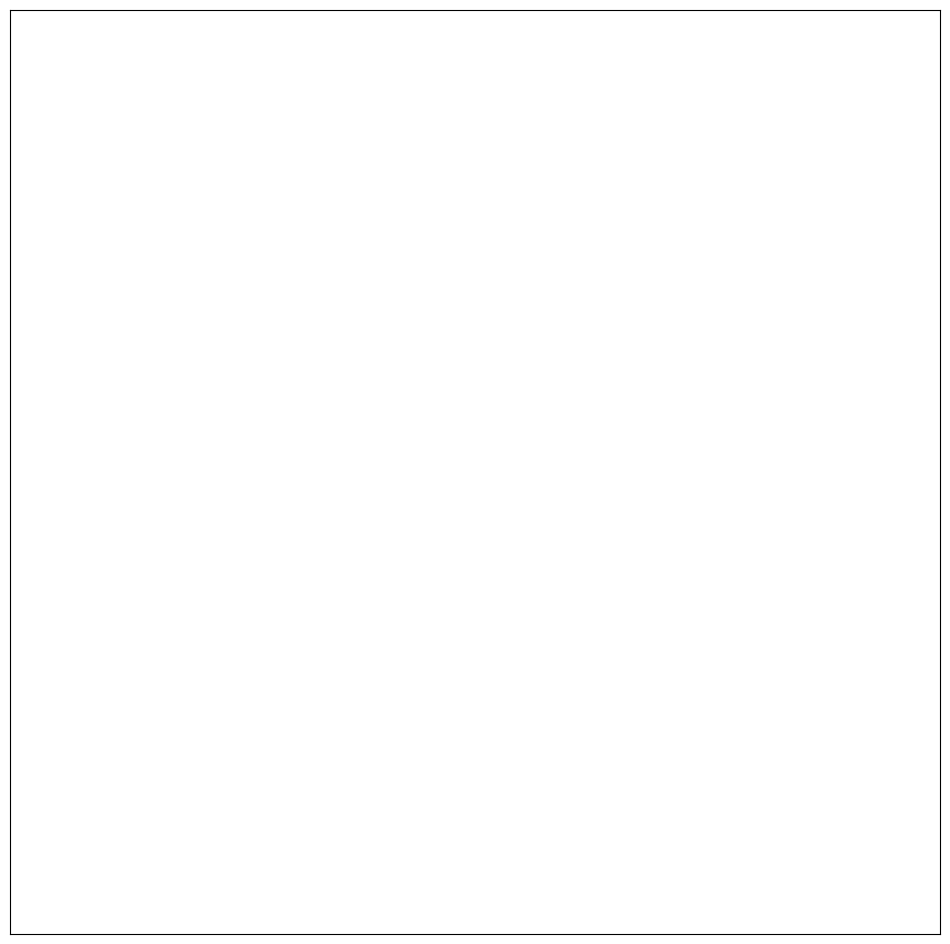

In [ ]:
show_batch(test_dl)

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize an empty list to store predictions
all_predictions = []

# Iterate through the test data
for test_batch in test_dl:  # Assuming test_dl is your DataLoader for the test data
    # Forward pass through the model for each element in the batch
    batch_predictions = []
    with torch.no_grad():  # To prevent gradient computation during inference
        for item in test_batch:
            item = item.to(torch.float)
            print(item.shape)
            item = item.to(device)  # Move the item to the appropriate device (CPU or GPU)
            output = model(item)
            batch_predictions.append(output)
            break

    # Concatenate the predictions for this batch
    batch_predictions = torch.cat(batch_predictions, dim=0)
    all_predictions.append(batch_predictions)

# Concatenate the predictions for all batches
all_predictions = torch.cat(all_predictions, dim=0)

# Now, all_predictions contains the predictions for your test data


torch.Size([128, 3, 224, 224])
torch.Size([52, 3, 224, 224])


tensor([[0.1503],
        [0.2870],
        [0.1597],
        [0.6085],
        [0.1323],
        [0.2676],
        [0.2989],
        [0.3867],
        [0.2248],
        [0.1455],
        [0.2163],
        [0.4839],
        [0.2837],
        [0.2444],
        [0.2447],
        [0.1670],
        [0.1076],
        [0.3051],
        [0.4500],
        [0.2144],
        [0.1981],
        [0.1396],
        [0.1821],
        [0.1642],
        [0.1078],
        [0.2692],
        [0.1456],
        [0.2966],
        [0.2747],
        [0.2840],
        [0.4012],
        [0.4287],
        [0.0929],
        [0.2337],
        [0.0683],
        [0.2420],
        [0.4622],
        [0.1643],
        [0.5213],
        [0.1175],
        [0.2987],
        [0.2396],
        [0.2009],
        [0.2486],
        [0.1398],
        [0.2229],
        [0.1663],
        [0.2238],
        [0.2367],
        [0.2133],
        [0.0900],
        [0.2261],
        [0.3247],
        [0.5086],
        [0.2794],
        [0

In [ ]:
threshold = 0.5
binary_labels = (all_predictions.cpu() >= threshold).int()

In [ ]:
test_df['Class'] = binary_labels

In [ ]:
test_df

,Image,Class
0,D3_429.jpg,0
1,D3_149.jpg,0
2,D5_377.jpg,0
3,D3_583.jpg,1
4,D3_232.jpg,0
...,...,...
175,D3_623.jpg,0
176,D5_330.jpg,0
177,D3_169.jpg,0
178,D5_389.jpg,0


In [ ]:
test_df.to_csv('result.csv')

In [ ]:
t_df = pd.read_csv('/content/world-championship-2023-embryo-classification/hvwc23/test.csv')

In [ ]:
test_df.head()

,Image,Class
0,D3_429.jpg,0
1,D3_149.jpg,0
2,D5_377.jpg,0
3,D3_583.jpg,1
4,D3_232.jpg,0


In [ ]:
t_df.head()

,ID,Image
0,1,D3_693.jpg
1,2,D3_212.jpg
2,3,D3_724.jpg
3,4,D3_623.jpg
4,5,D3_210.jpg


In [ ]:
t_df = t_df.merge(test_df, on='Image')
t_df.shape, t_df.head

((180, 3),
 <bound method NDFrame.head of       ID       Image  Class
 0      1  D3_693.jpg      0
 1      2  D3_212.jpg      0
 2      3  D3_724.jpg      0
 3      4  D3_623.jpg      0
 4      5  D3_210.jpg      0
 ..   ...         ...    ...
 175  176  D5_020.jpg      0
 176  177  D5_133.jpg      0
 177  178  D5_119.jpg      0
 178  179  D5_322.jpg      0
 179  180  D5_017.jpg      0
 
 [180 rows x 3 columns]>)

In [ ]:
t_df.drop(columns=['Image'], inplace= True)

In [ ]:
t_df.head()

,ID,Class
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
t_df.to_csv('r.csv',index=False)